In [1]:
!pip install pyspark==3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 13.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805893 sha256=431894df45c5aca711a9ca9df1eee892da4d478cd97cafdab2fba2525edba714
  Stored in directory: /root/.cache/pip/wheels/32/97/d3/8b6d964c8700e4fbb561c71638a92ec55dac9be51eb5fea86d
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [2]:
#Start spark sessnon and configureation
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
spark = SparkSession.builder.master("local[2]").appName("dat").getOrCreate()
sc = spark.sparkContext
#create an instance of SQLContext
sqlContext = SQLContext(spark)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/07 22:03:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
# Import libraries and other functions
from io import StringIO
from collections import namedtuple
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

import csv
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [4]:
LDNCrime = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").\
csv("/kaggle/input/3-cities-crime/Leicester_Derby_Nottingham Crime data 2021-22")

In [5]:
LDNCrime.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [6]:
# tidy up the column names

LDNCrime = LDNCrime.withColumnRenamed('Crime ID', 'Crime_ID')
LDNCrime = LDNCrime.withColumnRenamed('Reported by', 'Reported_by')
LDNCrime = LDNCrime.withColumnRenamed('Falls within', 'Falls_within')
LDNCrime = LDNCrime.withColumnRenamed('LSOA code', 'LSOA_code')
LDNCrime = LDNCrime.withColumnRenamed('LSOA name', 'LSOA_name')
LDNCrime = LDNCrime.withColumnRenamed('Crime type', 'Crime_type')
LDNCrime = LDNCrime.withColumnRenamed('Last outcome category', 'Last_outcome_category')

In [7]:
LDNCrime.printSchema()

root
 |-- Crime_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Context: string (nullable = true)



In [8]:
LDNCrime.take(2)

[Row(Crime_ID='669fa661520a6ef86a226893c1eacd5a503b7801b8cf6c6f153200a5628bf02e', Month='2022-05', Reported_by='Nottinghamshire Police', Falls_within='Nottinghamshire Police', Longitude=-1.375369, Latitude=53.099579, Location='On or near Priory Road', LSOA_code='E01019400', LSOA_name='Amber Valley 001A', Crime_type='Violence and sexual offences', Last_outcome_category='Status update unavailable', Context=None),
 Row(Crime_ID=None, Month='2022-05', Reported_by='Nottinghamshire Police', Falls_within='Nottinghamshire Police', Longitude=-1.329291, Latitude=53.021005, Location='On or near Bridge Street', LSOA_code='E01019453', LSOA_name='Amber Valley 017D', Crime_type='Anti-social behaviour', Last_outcome_category=None, Context=None)]

In [9]:
#get the counts for each month ordered in descending order
LDNCrime.groupby("Month").count().orderBy(desc("count")).show()

+-------+-----+
|  Month|count|
+-------+-----+
|2021-06|32975|
|2022-05|32872|
|2021-07|32286|
|2022-08|31867|
|2022-03|31359|
|2022-04|30723|
|2021-05|30720|
|2021-03|30717|
|2021-08|30060|
|2021-04|29992|
|2022-07|29625|
|2021-09|29614|
|2022-11|29547|
|2021-11|29091|
|2022-06|28952|
|2021-10|28585|
|2022-10|28515|
|2022-02|27338|
|2021-12|27046|
|2022-09|26870|
+-------+-----+
only showing top 20 rows



In [10]:
LDNCrime.groupby("Reported_by").count().orderBy(desc("count")).show()

+--------------------+------+
|         Reported_by| count|
+--------------------+------+
|Nottinghamshire P...|256640|
|Derbyshire Consta...|231754|
|Leicestershire Po...|214186|
+--------------------+------+



In [11]:
#retrieve yearly amount of crimes sorted descendantly
LDNCrime.select(substring(LDNCrime.Month, 1,4).alias('Year'), "Month")\
.groupby("Year").count().show()

+----+------+
|Year| count|
+----+------+
|2022|350134|
|2021|352446|
+----+------+



* Make a  line graph for each cities 
* piechart

In [12]:
#retrieve monthly amount of crimes (excluded year 2021) sorted descendantly
LDNCrime.\
select(substring(LDNCrime.Month, 6,7)\
                                                          \
       .alias('Month'), LDNCrime.Month.\
                                                          \
       alias('MonthWithYear')).groupby("Month").\
count().orderBy(desc("count")).show()

+-----+-----+
|Month|count|
+-----+-----+
|   05|63592|
|   03|62076|
|   08|61927|
|   06|61927|
|   07|61911|
|   04|60715|
|   11|58638|
|   10|57100|
|   09|56484|
|   12|53229|
|   02|52654|
|   01|52327|
+-----+-----+



In [13]:
#register temp tables 
LDNCrime.registerTempTable("tbl_LDNCrimes")

/opt/conda/lib/python3.10/site-packages/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


In [14]:
sqlContext.sql("select * from tbl_LDNCrimes").show(5)

+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+-----------------+--------------------+---------------------+-------+
|            Crime_ID|  Month|         Reported_by|        Falls_within|Longitude| Latitude|            Location|LSOA_code|        LSOA_name|          Crime_type|Last_outcome_category|Context|
+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+-----------------+--------------------+---------------------+-------+
|669fa661520a6ef86...|2022-05|Nottinghamshire P...|Nottinghamshire P...|-1.375369|53.099579|On or near Priory...|E01019400|Amber Valley 001A|Violence and sexu...| Status update una...|   null|
|                null|2022-05|Nottinghamshire P...|Nottinghamshire P...|-1.329291|53.021005|On or near Bridge...|E01019453|Amber Valley 017D|Anti-social behav...|                 null|   null|
|                null|2022-05|Notti

In [15]:
#retreive monthly crime amount and order by total in descending order
sqlContext.sql("select * from tbl_LDNCrimes order by Month desc").show()

+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+-----------------+--------------------+---------------------+-------+
|            Crime_ID|  Month|         Reported_by|        Falls_within|Longitude| Latitude|            Location|LSOA_code|        LSOA_name|          Crime_type|Last_outcome_category|Context|
+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+-----------------+--------------------+---------------------+-------+
|                null|2022-12|Derbyshire Consta...|Derbyshire Consta...|-1.385408|53.098319|         On or near |E01019401|Amber Valley 001B|Anti-social behav...|                 null|   null|
|b8220bd4b1a42f974...|2022-12|Derbyshire Consta...|Derbyshire Consta...|-1.373886|53.099904|On or near Cather...|E01019400|Amber Valley 001A|Violence and sexu...| Status update una...|   null|
|                null|2022-12|Derby

In [16]:
# Create new dataframe with Month and Counts per Month
LDNCrime_temp = LDNCrime.select(LDNCrime.Month)\
.groupby(LDNCrime.Month).count()

In [17]:
LDNCrime_temp.orderBy(desc("Month")).show()

+-------+-----+
|  Month|count|
+-------+-----+
|2022-12|26183|
|2022-11|29547|
|2022-10|28515|
|2022-09|26870|
|2022-08|31867|
|2022-07|29625|
|2022-06|28952|
|2022-05|32872|
|2022-04|30723|
|2022-03|31359|
|2022-02|27338|
|2022-01|26283|
|2021-12|27046|
|2021-11|29091|
|2021-10|28585|
|2021-09|29614|
|2021-08|30060|
|2021-07|32286|
|2021-06|32975|
|2021-05|30720|
+-------+-----+
only showing top 20 rows



In [18]:
LDNCrime_temp.registerTempTable("tbl_LDNCrime_temp")

In [19]:
# Create new dataframe with month, total, and averages
monthlyCrimeAmount = sqlContext.\
sql("select substring(Month, 6, 2) as Month, \
SUM(count) as Total, avg(count) as \
Average from tbl_LDNCrime_temp group by substring(Month, 6, 2)")

In [20]:
monthlyCrimeAmountnew = monthlyCrimeAmount.orderBy('Month')

In [21]:
monthlyCrimeAmountnew.show()

+-----+-----+-------+
|Month|Total|Average|
+-----+-----+-------+
|   01|52327|26163.5|
|   02|52654|26327.0|
|   03|62076|31038.0|
|   04|60715|30357.5|
|   05|63592|31796.0|
|   06|61927|30963.5|
|   07|61911|30955.5|
|   08|61927|30963.5|
|   09|56484|28242.0|
|   10|57100|28550.0|
|   11|58638|29319.0|
|   12|53229|26614.5|
+-----+-----+-------+



In [22]:
# Register the monthlyCrimeAmount 
# DataFrame as a temp table and show the contents
monthlyCrimeAmountnew.registerTempTable("monthlyCrimeAmount")
sqlContext.sql("select * from monthlyCrimeAmount").show()

+-----+-----+-------+
|Month|Total|Average|
+-----+-----+-------+
|   01|52327|26163.5|
|   02|52654|26327.0|
|   03|62076|31038.0|
|   04|60715|30357.5|
|   05|63592|31796.0|
|   06|61927|30963.5|
|   07|61911|30955.5|
|   08|61927|30963.5|
|   09|56484|28242.0|
|   10|57100|28550.0|
|   11|58638|29319.0|
|   12|53229|26614.5|
+-----+-----+-------+



In [23]:
# Prepare variables for visualisations

monthArray = sqlContext.sql("select Month from monthlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()
monthTotalArray = sqlContext.sql("select Total from monthlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()
monthAvgArray = sqlContext.sql("select Average from monthlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()

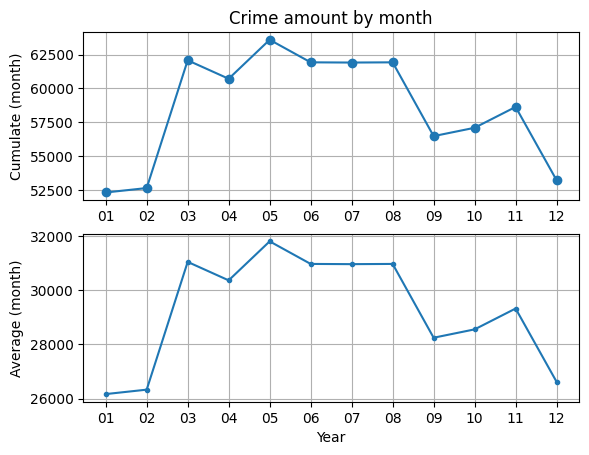

In [24]:
# Plot visualisations

import matplotlib.pyplot as plt
import numpy as np

y = monthArray
t = monthTotalArray
a = monthAvgArray

plt.subplot(2, 1, 1)
plt.plot(y, t, 'o-')
plt.title('Crime amount by month')
plt.ylabel('Cumulate (month)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y, a, '.-')
plt.xlabel('Year')
plt.ylabel('Average (month)')
plt.grid(True)
plt.savefig("yearlyCrimeAmount.png")

In [25]:
# Create dataframe to retrieve information by year (total and average)plt.show()
yearlyCrimeAmount = sqlContext.sql("select substring(Month, 0, 4) \
as Year, SUM(count) as Total, avg(count) as Average from \
tbl_LDNCrime_temp group by substring(Month, 0, 4)")

In [26]:
yearlyCrimeAmount

DataFrame[Year: string, Total: bigint, Average: double]

In [27]:
yearlyCrimeAmount.show()

+----+------+------------------+
|Year| Total|           Average|
+----+------+------------------+
|2022|350134|29177.833333333332|
|2021|352446|           29370.5|
+----+------+------------------+



In [28]:
yearlyCrimeAmount.registerTempTable("yearlyCrimeAmount")
sqlContext.sql("select * from yearlyCrimeAmount").show()

+----+------+------------------+
|Year| Total|           Average|
+----+------+------------------+
|2022|350134|29177.833333333332|
|2021|352446|           29370.5|
+----+------+------------------+



In [29]:
# Prepare variables for visualisations

totalArray = sqlContext.sql("select Total from yearlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()
yearArray = sqlContext.sql("select Year from yearlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()
averageArray = sqlContext.sql("select Average from yearlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()

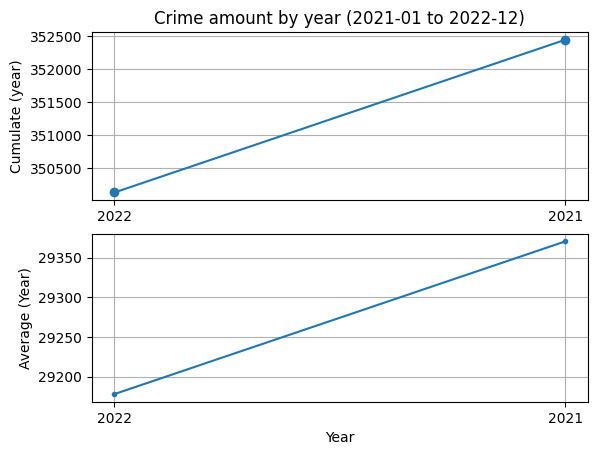

In [30]:
# Plot visualisations
import matplotlib.pyplot as plt
import numpy as np

y = yearArray
t = totalArray
a = averageArray

plt.subplot(2, 1, 1)
plt.plot(y, t, 'o-')
plt.title('Crime amount by year (2021-01 to 2022-12)')
plt.ylabel('Cumulate (year)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y, a, '.-')
plt.xlabel('Year')
plt.ylabel('Average (Year)')
plt.grid(True)
plt.savefig("yearlyCrimeAmount.png")
plt.show()

In [31]:
sqlContext.sql("select Month, substring(Month, 0, 4) \
as Year, count(*) as Count from tbl_LDNCrimes group by Month").show()

+-------+----+-----+
|  Month|Year|Count|
+-------+----+-----+
|2021-07|2021|32286|
|2022-04|2022|30723|
|2021-04|2021|29992|
|2021-06|2021|32975|
|2022-02|2022|27338|
|2022-08|2022|31867|
|2021-11|2021|29091|
|2021-03|2021|30717|
|2022-11|2022|29547|
|2021-05|2021|30720|
|2022-03|2022|31359|
|2022-05|2022|32872|
|2021-08|2021|30060|
|2021-09|2021|29614|
|2022-06|2022|28952|
|2022-07|2022|29625|
|2021-10|2021|28585|
|2021-12|2021|27046|
|2022-10|2022|28515|
|2022-09|2022|26870|
+-------+----+-----+
only showing top 20 rows



In [32]:
LDNCrime.registerTempTable("tbl_LDNCrime_type")

In [33]:
CrimeTypes = sqlContext.sql("select Crime_type, Month, \
substring(Month, 0, 4) as Year,\
count(*) as Count from tbl_LDNCrime_type group by Month, Crime_type")

In [34]:
CrimeTypes.show()

+--------------------+-------+----+-----+
|          Crime_type|  Month|Year|Count|
+--------------------+-------+----+-----+
|Anti-social behav...|2022-03|2022| 5644|
|         Shoplifting|2022-11|2022| 1711|
|         Other theft|2022-02|2022| 1832|
|Anti-social behav...|2021-04|2021| 7886|
|Possession of wea...|2021-08|2021|  261|
|Possession of wea...|2022-05|2022|  282|
|             Robbery|2021-05|2021|  193|
|Criminal damage a...|2021-03|2021| 2409|
|               Drugs|2021-07|2021|  783|
|       Bicycle theft|2021-11|2021|  349|
|Violence and sexu...|2021-04|2021| 9494|
|Violence and sexu...|2021-07|2021|11138|
|             Robbery|2021-07|2021|  199|
|Possession of wea...|2021-06|2021|  229|
|Criminal damage a...|2022-08|2022| 2754|
|Possession of wea...|2021-07|2021|  252|
|        Public order|2021-05|2021| 2778|
|Theft from the pe...|2022-05|2022|  263|
|Violence and sexu...|2022-04|2022|10114|
|         Other crime|2021-11|2021|  572|
+--------------------+-------+----

In [35]:
# Explore Crime Types per year/month

CrimeTypesGeo = sqlContext.sql("select Crime_type, Month, \
substring(Month, 0, 4) as Year, Latitude, Longitude, \
count(*) as Count from tbl_LDNCrime_type group by Month, \
Crime_type, Latitude, Longitude")

In [36]:
CrimeTypesGeo.registerTempTable("CrimeTypesGeo")
sqlContext.sql("select * from CrimeTypesGeo").show()

+--------------------+-------+----+---------+---------+-----+
|          Crime_type|  Month|Year| Latitude|Longitude|Count|
+--------------------+-------+----+---------+---------+-----+
|Violence and sexu...|2022-05|2022|53.141122|  -1.2761|    1|
|Criminal damage a...|2022-05|2022|53.132636|-1.258456|    1|
|Anti-social behav...|2022-05|2022|53.126363|-1.308015|    1|
|Violence and sexu...|2022-05|2022| 53.13333|-1.312746|    1|
|Violence and sexu...|2022-05|2022|53.117411|-1.258913|    3|
|        Public order|2022-05|2022|53.099269|-1.247172|    1|
|Violence and sexu...|2022-05|2022|53.105661|-1.254335|    1|
|         Other theft|2022-05|2022|53.037324| -1.21383|    1|
|Criminal damage a...|2022-05|2022|53.027406|-1.222971|    1|
|Possession of wea...|2022-05|2022| 53.38811|-1.063685|    1|
|         Other crime|2022-05|2022|53.379513|-1.128485|    1|
|Criminal damage a...|2022-05|2022|53.320815| -0.94171|    1|
|Criminal damage a...|2022-05|2022|53.285367|-1.103672|    1|
|Violenc

In [37]:
# Prepare variables for visualisations

totalArray = sqlContext.sql("select Total from yearlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()
yearArray = sqlContext.sql("select Year from yearlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()
averageArray = sqlContext.sql("select Average from yearlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()

In [38]:
sqlContext.sql("select Reported_by, count(*) \
as Count from tbl_LDNCrimes group by Reported_by").show()

+--------------------+------+
|         Reported_by| Count|
+--------------------+------+
|Leicestershire Po...|214186|
|Derbyshire Consta...|231754|
|Nottinghamshire P...|256640|
+--------------------+------+

